In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import theano.tensor as tt
import theano

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


In [2]:
data = pd.read_csv('datasets/antiseptic-amputation.csv', header=None)
data.columns = ['subject', 'year', 'antiseptic', 'limb', 'outcome']
data.set_index('subject', inplace=True)

# Data normalization
data['year'] = data['year'] - data['year'].min()
data = pm.floatX(data)
data.head()

,year,antiseptic,limb,outcome
subject,,,,
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,1.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0
5,0.0,0.0,1.0,1.0


The logistic function is defined as

$$ p = \frac{1}{1 + e^{-k}}$$

Here, the $k$ term refers to:

$$ k = \beta_{n}x_{1} + \beta_{2}x_{2} + ... + \beta_{n}x_{n} $$

Therefore, we will write it in as such

In [3]:
import theano.tensor as tt
# data = pm.floatX(data)

def logit(x):
    return np.exp(x) / (1 + np.exp(x))

with pm.Model() as model:
    pm.glm.linear.GLM(x=data[['year', 'antiseptic', 'limb']], y=data['outcome'])

In [4]:
with model:
    trace = pm.sample(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 90.434:  10%|█         | 20129/200000 [00:08<01:09, 2576.78it/s]
Convergence archived at 20300
Interrupted at 20,300 [10%]: Average Loss = 173.84
100%|██████████| 2500/2500 [00:15<00:00, 161.08it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3823826198>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f383e5e42e8>]], dtype=object)

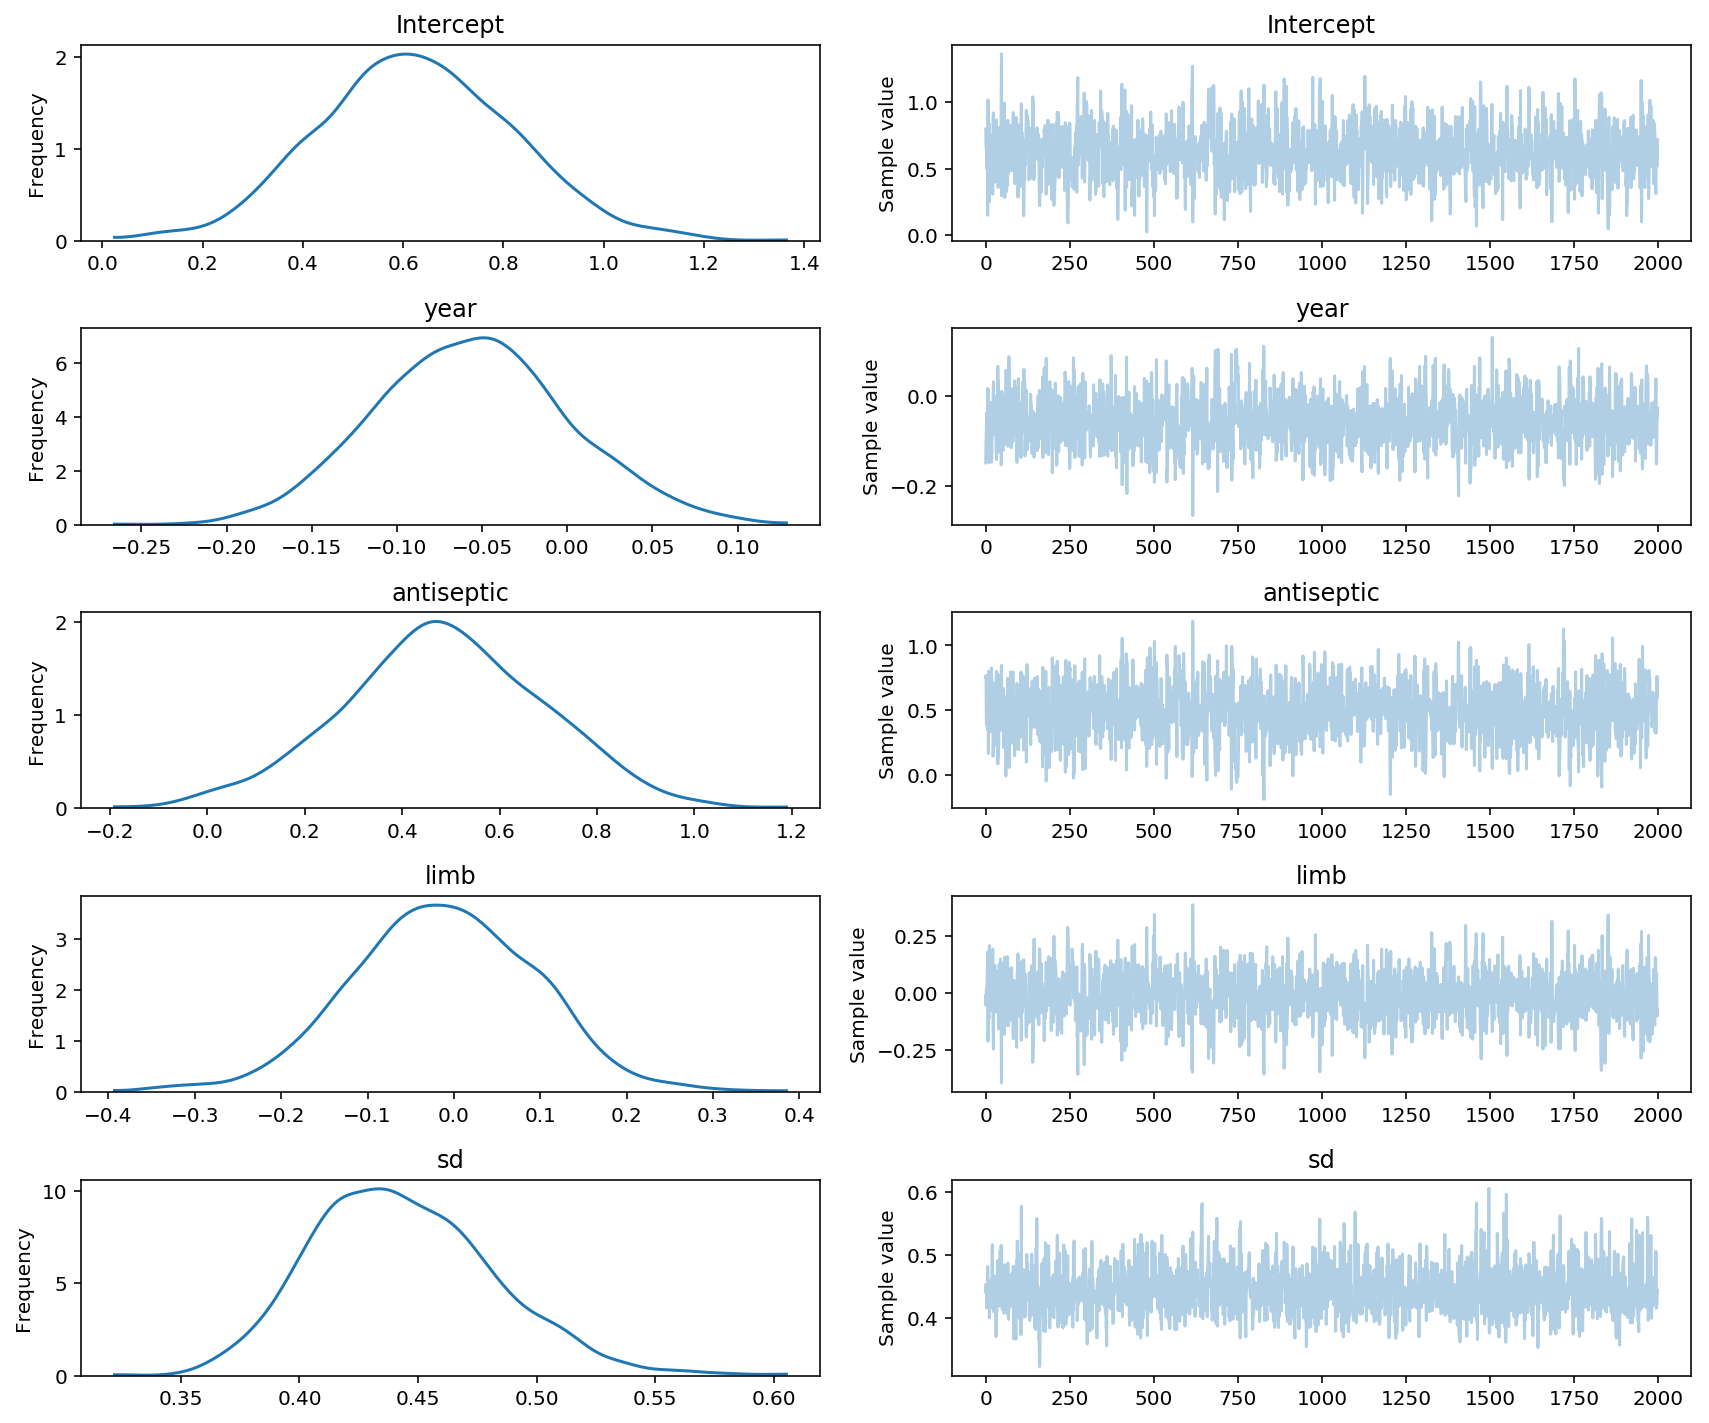

In [51]:
pm.traceplot(trace)

Posterior predictive check.

In [52]:
ppc = pm.sample_ppc(trace, model=model, samples=500)

100%|██████████| 500/500 [00:01<00:00, 362.68it/s]


In [55]:
ppc['y'].mean(axis=0)

array([ 0.57341688,  0.57740272,  0.61523509,  0.61326379,  0.61076967,
        0.57337458,  0.66436745,  0.64944674,  0.55668286,  0.60743965,
        0.60363152,  0.63926912,  0.58818491,  0.59506413,  0.56691266,
        0.59947137,  0.63031497,  0.53078378,  0.4628746 ,  0.50488442,
        0.4955216 ,  0.50833584,  0.53512472,  0.49021577,  0.49946713,
        0.49099532,  0.46440544,  0.47402072,  0.44201306,  0.50118111,
        0.48418122,  0.47395611,  0.5238108 ,  0.50681302,  0.4884631 ,
        0.97548929,  0.93873992,  0.92398145,  0.94179132,  0.92203673,
        0.92145693,  0.88195128,  0.89514285,  0.90241945,  0.87641391,
        0.85182086,  0.89111399,  0.8252867 ,  0.87067031,  0.87627462,
        0.86335839,  0.87607185,  0.85508349,  0.88213527,  0.8922643 ,
        0.88019404,  0.87690204,  0.87478343,  0.83599054,  0.80244332,
        0.82306069,  0.81913925,  0.84239339,  0.80522853,  0.82291287,
        0.81790006,  0.79431072,  0.77050644,  0.79023938,  0.77

In [57]:
preds = np.rint(ppc['y'].mean(axis=0)).astype('int')

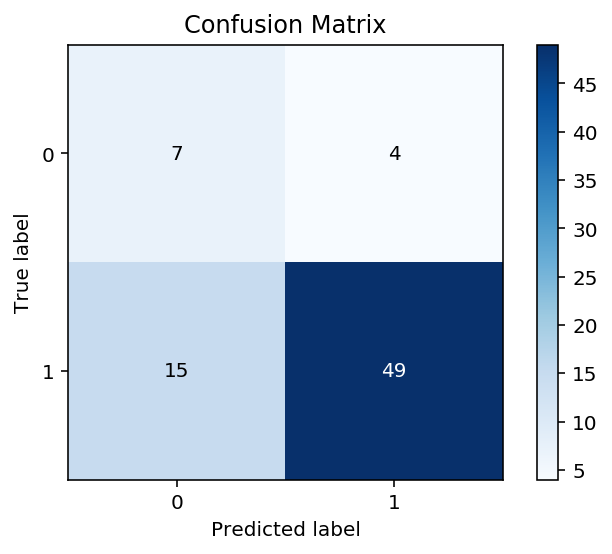

In [58]:
from scikitplot.plotters import plot_confusion_matrix

plot_confusion_matrix(preds, data['outcome'])

In [60]:
from sklearn.metrics import accuracy_score

accuracy_score(preds, data['outcome'])

0.7466666666666667

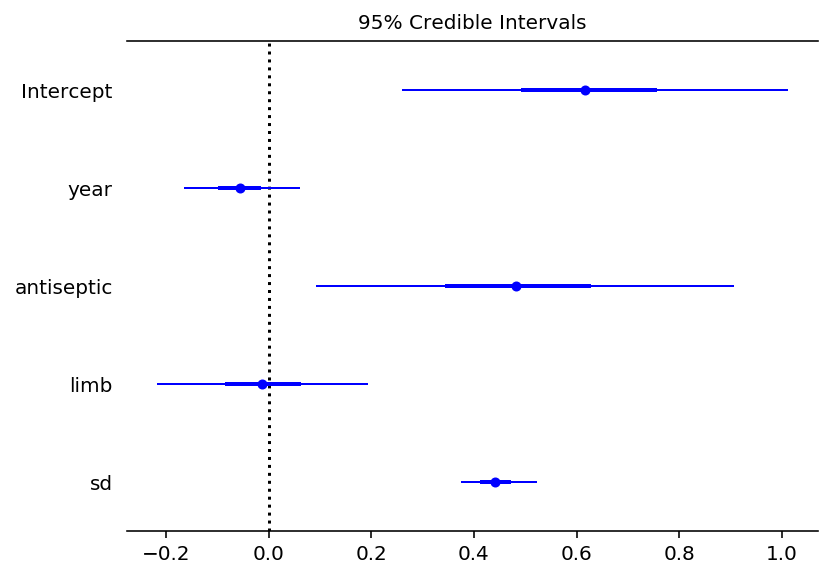

In [62]:
pm.forestplot(trace,)

There's a baseline probability of survival, and a little bit of an error term that governs whether a limb will survive or not. Beyond that, antiseptics have the biggest effect on limb survival.